# Аналитика поведения пользователей мобильного приложения для покупки продуктов питания

- Изучим воронку продаж. 
- Исследуем результаты A/A/B-эксперимента. 

### План:
1. Загрузим и изучим данные разными методами, чтобы проверить пропуски, типы данных и познакомиться с самими данными, которые доступны для исследования. Предобработаем данные при необходимости.


2. Проанализируем данные:
    - Сколько всего событий в логе.
    - Сколько всего пользователей в логе.
    - Сколько в среднем событий приходится на пользователя.
    - Определим, данными за какой период мы располагаем.
    - Определим, с какого момента мы имеем полные данные за весь период, и отбросим более старые.
    - Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.


3. Изучим воронку событий:
    - Посмотрим, какие события есть в логах, как часто они встречаются.
    - Посчитаем, сколько пользователей совершали каждое из этих событий.
    - Попробуем понять, в каком порядке происходят события.
    - По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки.
    - Определим, на каком шаге теряем больше всего пользователей.
    - Узнаем, какая доля пользователей доходит от первого события до оплаты.


4. Изучим результаты эксперимента:
    - Сколько пользователей в каждой экспериментальной группе.
    - Проверим, находят ли статистические критерии разницу между выборками из 2-х контрольных групп для А/А-эксперимента.
    - Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.


5. Сформируем выводы.

<a name="researchdata"></a>

## Шаг 1. Откроем файлы с данными и изучим общую информацию, предобработаем данные

Импортируем библиотеки:

In [50]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import math as mth

import warnings
warnings.filterwarnings("ignore")

Загружаем файл с данными о поведении пользователей нашего мобильного приложения (дополнительно добавлен разделитель для данных sep):

In [51]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

**Посмотрим на сам датасет**

In [52]:
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Посмотрим на общую информацию по датасету**

In [53]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Проверим дубликаты**

In [54]:
logs.duplicated().sum()

413

Удалим дубли:

In [55]:
logs = logs.drop_duplicates()

### Вывод

1. Пропусков в данных нет.

2. Удалили 413 полных дубликатов.

3. Стоит переименовать столбы для удобства работы с ними в дальнейшем.

4. Необходимо разобраться со столбцом EventTimestamp, нам будут нужны даты и время событий.

**Переименуем столбцы**

In [56]:
logs = logs.rename(columns={'EventName': 'event_name',
                            'DeviceIDHash': 'user_id',
                            'EventTimestamp': 'event_timestamp',
                            'ExpId': 'group'})

logs.head()

,event_name,user_id,event_timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Разберёмся с данными о времени события**

Добавим столбец даты и времени. Для этого переведём данные из столбца event_timestamp в тип данных datetime и сохраним в отдельный столбец:

In [57]:
logs['event_datetime'] = pd.to_datetime(logs['event_timestamp'], unit='s')

# проверяем
display(logs.head())

,event_name,user_id,event_timestamp,group,event_datetime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


Также добавим отдельный столбец дат:

In [58]:
logs['event_date'] = pd.to_datetime(logs['event_datetime']).dt.date

# проверям
logs['event_date'].head()

0    2019-07-25
1    2019-07-25
2    2019-07-25
3    2019-07-25
4    2019-07-25
Name: event_date, dtype: object

Видим, что у столбца event_date тип данных object. Поменяем его на datetime64:

In [59]:
logs['event_date'] = logs['event_date'].apply(pd.to_datetime, format='%Y-%m-%d')

# проверям
logs['event_date'].dtypes

dtype('<M8[ns]')

<a name="analysis"></a>

## Шаг 2. Изучим и проверим данные

1. Сколько всего событий в логе.
1. Сколько всего пользователей в логе.
1. Сколько в среднем событий приходится на пользователя.
1. Определим, данными за какой период мы располагаем:
    - найдём максимальную и минимальную дату,
    - построим гистограмму по дате и времени.
1. Определим, с какого момента мы имеем полные данные за весь период и отбросим более старые (сколько событий и пользователей мы потеряли, отбросив старые данные).
1. Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

<a name="eventscount"></a>

**1. Посчитаем, сколько всего событий в логе**

In [60]:
events_unique = logs['event_name'].nunique()

print('Всего событий в логе: {}'.format(events_unique))
print()

# посмотрим на сами события
print(logs['event_name'].unique())

Всего событий в логе: 5

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


***Выводы***

Всего у нас выделено пять событий:
- MainScreenAppear - пользователь зашёл на главную страницу
- Tutorial - пользователь посмотрел туториал
- OffersScreenAppear - пользователь перешёл на страницу товара
- CartScreenAppear - пользователь добавил товар в корзину
- PaymentScreenSuccessful - пользователь оплатил заказ

<a name="userscount"></a>

**2. Посчитаем, сколько всего пользователей в логе**

In [61]:
users_unique = logs['user_id'].nunique()

print('Всего пользователей в логе: {}'.format(users_unique))

Всего пользователей в логе: 7551


<a name="avgeventsperuser"></a>

**3. Посчитаем, сколько в среднем событий приходится на пользователя**

Сгруппируем данные по пользователям, посчитаем общее количество событий на каждого и найдём среднее:

In [62]:
logs.groupby('user_id')['event_name'].count().mean().round()

32.0

***Выводы***

В среднем на одного пользователя приходится по 32 события.

<a name="dataperiod"></a>

**4. Определим, данными за какой период мы располагаем**

Найдём максимальную и минимальную даты:

In [63]:
print(logs['event_date'].max())
print(logs['event_date'].min())

2019-08-07 00:00:00
2019-07-25 00:00:00


Построим гистограмму по дате и времени:

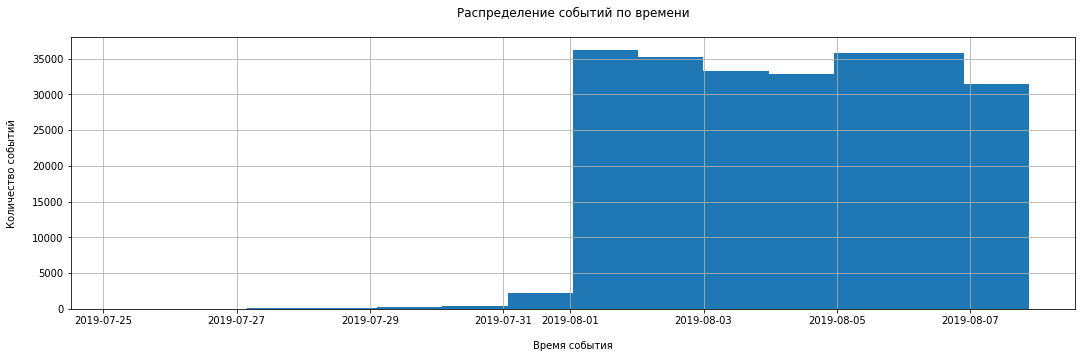

In [64]:
logs['event_datetime'].hist(grid=True, bins=14, figsize=(18, 5))
plt.title('Распределение событий по времени', pad = 20)
plt.xlabel('Время события', labelpad = 15)
plt.ylabel('Количество событий', labelpad = 15)
plt.show();

<a name="fulldataperiod"></a>

**5. Определим, с какого момента мы имеем полные данные за весь период, и отбросим более старые**

Судя по гистограмме из прошлого шага, основные события происходили с первого по седьмое августа. До 01.08.2019 событий совсем мало.

Оставим в датасете только данные, начиная с 1 августа, сохраним их в отдельную таблицу:

In [65]:
logs_actual = logs[logs['event_date'] >= '2019-08-01']

# проверяем
logs_actual.head()

,event_name,user_id,event_timestamp,group,event_datetime,event_date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


Посчитаем, сколько событий и пользователей мы потеряли, отбросив старые данные:

In [66]:
print('Сколько всего событий мы потеряли:', len(logs) - len(logs_actual))
print('Какой процент старых данных мы отрезали:', ((len(logs) - len(logs_actual)) / len(logs)) * 100)

Сколько всего событий мы потеряли: 2826
Какой процент старых данных мы отрезали: 1.159560630741897


In [67]:
print('Сколько уникальных пользователей мы потеряли:', logs['user_id'].nunique() - logs_actual['user_id'].nunique())
print('Какую долю уникальных пользователей мы отрезали:', ((logs['user_id'].nunique() - logs_actual['user_id'].nunique()) 
                                                           / logs['user_id'].nunique()) * 100)

Сколько уникальных пользователей мы потеряли: 17
Какую долю уникальных пользователей мы отрезали: 0.22513574361011784


***Выводы***

Основные события происходили с первого по седьмое августа, поэтому мы отфильтровали наш датасет по этим датам.

Отрезав старые данные, мы удалили 2826 событий (примерно 1.16% от данных) и 17 пользователей (около 0.23%). Зато оставшиеся данные являются наиболее полными и информативными.

<a name="usersgroup"></a>

**6. Проверим, что у нас есть пользователи из всех трёх экспериментальных групп**

Сгруппируем пользователей по группам экспериментов и посчитаем количество пользователей, совершивших события, в каждой группе:

In [68]:
logs_actual.groupby('group')['user_id'].nunique()

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

***Выводы***

У нас есть пользователи каждой группы эксперимента. 

<a name="funnel"></a>

## Шаг 3. Изучим воронку событий

1. Посмотрим, какие события есть в логах, как часто они встречаются.
1. Посчитаем, сколько пользователей совершали каждое из этих событий. Посчитаем долю пользователей, которые хоть раз совершали событие.
1. Попробуем понять, в каком порядке происходят события, все ли они выстраиваются в последовательную цепочку.
1. По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки. 
1. Определим, на каком шаге теряем больше всего пользователей.
1. Узнаем, какая доля пользователей доходит от первого события до оплаты.

<a name="eventslog"></a>

**1. Посмотрим, какие события есть в логах, как часто они встречаются, отсортируем их по частоте**

In [69]:
event_count = logs_actual.groupby('event_name')['user_id'].count().sort_values(ascending=False).reset_index()
event_count.columns = ['event_name', 'event_count']

event_count

,event_name,event_count
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


***Выводы***

На главный экран ожидаемо попадает больше всего пользователей, а вот до просмотра туториала доходит совсем мало.

<a name="userseventscount"></a>

**2. Посчитаем, сколько пользователей совершали каждое из этих событий, посчитаем их долю**

Отсортируем события по числу пользователей:

In [70]:
event_user_count = logs_actual.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
event_user_count.columns = ['event_name', 'user_count']

event_user_count

,event_name,user_count
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Посчитаем долю пользователей, которые хоть раз совершали каждое событие. Для этого поделим количество пользователей на каждом шаге на общее количество пользователей:

In [71]:
event_user_count['ratio'] = ((event_user_count['user_count'] / logs_actual['user_id'].nunique()) * 100).round()
event_user_count

,event_name,user_count,ratio
0,MainScreenAppear,7419,98.0
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.0


***Выводы***

- Почти все пользователи прошли через основной экран (98%).
- 61% пользователей доходит до просмотра товаров.
- Половина пользователей положила товар в корзину. И почти половина оплатила товары в корзине.
- Туториал посмотрели только 11% наших пользователей.

<a name="eventschain"></a>

**3. Предположим, в каком порядке происходят события, все ли они выстраиваются в последовательную цепочку.**

Полученная на предыдущем шаге воронка выстроена верно, за исключением шага просмотра туториала. 

Он должен обучать, как пользоваться приложением, т.е. быть первым или вторым в воронке, но почти 90% пользователей им пренебрегают. С другой стороны, этот шаг совсем необязателен и не должен влиять на покупку товара. Если приложение изначально имеет понятный интерфейс или пользователь уже не новичок в онлайн покупках, то вполне можно обойтись и без туториала.

Будем рассматривать воронку шагов без учёта шага просмотра туториала. 

Далее посмотрим, сколько пользователей переходит последовательно с этапа на этап.

<a name="nextstepratio"></a>

**4. По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки** (от числа пользователей на предыдущем)

Нам необходимо изучить детали перехода с этапа на этап. 

Для начала по каждому пользователю посчитаем, в какое время он впервые совершил определённое событие. Найдём тех, чьи события происходили в нужном порядке.

Посчитаем время первого срабатывания каждого события:

In [72]:
users_log = logs_actual.pivot_table(
        index='user_id', 
        columns='event_name', 
        values='event_datetime',
        aggfunc='min')

users_log.head()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
user_id,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT


Видим, что если пользователь не совершал какое-то событие, в его ячейке стоит NaT.

Узнаем, сколько пользователей переходило с этапа на этап последовательно:
1. Сначала найдём число строк таблицы users, где в столбце MainScreenAppear не пустое значение (т.е. пользователь прошёл через главную страницу).
2. Затем определим, сколько людей из тех, кто прошли через главную страницу, перешли к выбору товара (дата события OffersScreenAppear позже даты первого захода на главную страницу).
3. По аналогии добавим остальные шаги (добавление товара в корзину и оплата) и получим воронку. 
4. Наконец, посчитаем, какая доля пользователей проходит на следующий шаг воронки.

Чтобы код был читаемым, вынесем условия каждого шага в соответствующие переменные:

In [73]:
# выстраиваем последовательность шагов по времени
step_1 = ~users_log['MainScreenAppear'].isna()
step_2 = step_1 & (users_log['OffersScreenAppear'] > users_log['MainScreenAppear'])
step_3 = step_2 & (users_log['CartScreenAppear'] > users_log['OffersScreenAppear'])
step_4 = step_3 & (users_log['PaymentScreenSuccessful'] > users_log['CartScreenAppear'])

# сохраним количество пользователей, прошедших по шагам
n_mainscreen = users_log[step_1].shape[0]
n_offersscreen = users_log[step_2].shape[0]
n_cartscreen = users_log[step_3].shape[0]
n_paymentscreen = users_log[step_4].shape[0]

# считаем долю пользователей, переходивших с одного шага на другой
r_main = n_mainscreen/n_mainscreen * 100
r_offer = n_offersscreen/n_mainscreen * 100
r_cart = n_cartscreen/n_offersscreen * 100
r_pay = n_paymentscreen/n_cartscreen * 100

Создадим из полученных данных датафрейм:

In [74]:
data = {'event_name':['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'], 
        'user_step_count':[n_mainscreen, n_offersscreen, n_cartscreen, n_paymentscreen],
        'ratio_step':[r_main, r_offer, r_cart, r_pay]}

event_user_step_count = pd.DataFrame(data)

# округлим доли до целых чисел
event_user_step_count['ratio_step'] = event_user_step_count['ratio_step'].round()

event_user_step_count

,event_name,user_step_count,ratio_step
0,MainScreenAppear,7419,100.0
1,OffersScreenAppear,4201,57.0
2,CartScreenAppear,1767,42.0
3,PaymentScreenSuccessful,454,26.0


Вспомним, как выглядит простая воронка:

In [75]:
event_user_count

,event_name,user_count,ratio
0,MainScreenAppear,7419,98.0
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0
4,Tutorial,840,11.0


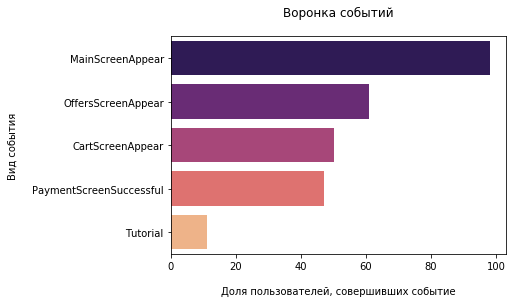

In [76]:
sns.barplot(data=event_user_count, x='ratio', y='event_name', palette = 'magma')
plt.title('Воронка событий', pad=20)
plt.xlabel('Доля пользователей, совершивших событие', labelpad = 15)
plt.ylabel('Вид события', labelpad = 15)
plt.show();

***Выводы***

Полученная воронка с учётом порядка действий пользователей отличается от простой воронки, посчитанной ранее.
Это значит, что не все пользователи идут по ожидаемому пути.

<a name="steplostusers"></a>

**5. Определим, на каком шаге теряем больше всего пользователей**

Мы видим, что 57% пользователей, посмотревших главную страницу, доходит до просмотра товаров.
Т.е. ко второму шагу отсеивается 43% пользователей. Возможно, они просто скачали приложение для ознакомления. 

Другая крупная потеря - всего 1/4 наших пользователей, после того как положили товар в корзину, доходит до его оплаты.

<a name="fullstepsratio"></a>

**6. Узнаем, какая доля пользователей доходит от первого события до оплаты**

Для этого поделим количество пользователей на каждом шаге на количество пользователей на первом шаге:

In [77]:
event_user_step_count['ratio_total'] = (((event_user_step_count['user_step_count'] / 
                                          event_user_step_count['user_step_count'][0]) * 100).round())
event_user_step_count

,event_name,user_step_count,ratio_step,ratio_total
0,MainScreenAppear,7419,100.0,100.0
1,OffersScreenAppear,4201,57.0,57.0
2,CartScreenAppear,1767,42.0,24.0
3,PaymentScreenSuccessful,454,26.0,6.0


***Выводы***

Всего лишь 6% пользователей, прошедших через все шаги, оплачивает выбранные товары.

<a name="experiment"></a>

## Шаг 4. Изучим результаты эксперимента

1. Сколько пользователей в каждой экспериментальной группе.
2. Проверим, находят ли статистические критерии разницу между выборками 246 и 247 (2 контрольные группы для А/А-эксперимента).
   
   Для всех событий:
    - посчитаем число пользователей, совершивших это событие в каждой из контрольных групп,
    - посчитаем долю пользователей, совершивших это событие,
    - проверим, будет ли отличие между группами статистически достоверным. 
    
    
3. Аналогично поступим с группой с изменённым шрифтом. 
    - Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. 
    - Сравним результаты с объединённой контрольной группой. 

<a name="userscountpergroup"></a>

**1. Сколько пользователей в каждой экспериментальной группе**

Посчитаем количество пользователей в каждой группе:

In [78]:
group_uniqusers_count = logs_actual.groupby('group')['user_id'].nunique().reset_index()
group_uniqusers_count.columns = ['group', 'users_count']

group_uniqusers_count

,group,users_count
0,246,2484
1,247,2513
2,248,2537


Сохраним всех пользователей из групп в списки и проверим, нет ли у нас пользователей, попавших сразу в несколько групп:

In [79]:
group_A1 = logs_actual.query('group == 246')['user_id'].tolist()
group_A2 = logs_actual.query('group == 247')['user_id'].tolist() 
group_B = logs_actual.query('group == 248')['user_id'].tolist() 

print(len(logs_actual[logs_actual['group'] == 247].query('user_id in @group_A1')))
print(len(logs_actual[logs_actual['group'] == 248].query('user_id in @group_A1')))
print(len(logs_actual[logs_actual['group'] == 248].query('user_id in @group_A2')))

0
0
0


Все наши пользователи разделены по группам, всё в порядке.

<a name="statsratioaa"></a>

**2. Проверим, находят ли статистические критерии разницу между выборками 246 и 247** (2 контрольные группы для А/А-эксперимента)

Посчитаем число пользователей, совершивших событие в каждой из контрольных групп, их долю и проверим, будет ли отличие между группами статистически достоверным.

**Сформулируем гипотезы, которые будем проверять:**

- Нулевая гипотеза: ***Доли пользователей, совершивших событие, в группах равны.***
- Альтернативная гипотеза: ***Доли пользователей, совершивших событие, в группах различаются.***

Сохраним интересующие нас события в отдельный список:

In [80]:
events_name = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

Напишем функцию, которая на вход будет получать 4 параметра (по 2 от каждой сравниваемой группы): 
- результаты переходов на шаг с событием,
- размеры самих групп.

Это позволит нам вычислить долю пользователей, перешедших на определённый шаг.

Внутри этой же функции проведём тест, чтобы узнать, будет ли отличие между группами статистически достоверным.
Параметр alpha зададим равным 0.05:

In [81]:
def check_ratio(step1, step2, group1, group2, alpha=0.05):
    """Функция для проверки гипотез о равенстве долей
    
    Аргументы:
        step1, step2: количество уникальных пользователей, совершивших событие, в сравниваемых группах 
        group1, group2: количество уникальных пользователей в сравниваемых группах
        alpha=0.05: зафиксированное значение alpha (уровень значимости)
    
    Возвращает:
        p_value: p-значение
        результат проверки гипотезы
    
    """
    # доля пользователей, совершивших событие в первой группе:
    p1 = step1/group1
    # доля пользователей, совершивших событие во второй группе:
    p2 = step2/group2
    # доля пользователей, совершивших событие в комбинированном датасете:
    p_combined = (step1 + step2) / (group1 + group2)
    # разница долей в датасетах
    difference = p1 - p2
   
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group1 + 1/group2))
 
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
 
    # рассчитаем вероятность - вызовем метод cdf, саму статистику возьмём по модулю методом abs, 
    # чтобы получить правильный результат независимо от знака, потому что тест двусторонний, поэтому же удваиваем результат
    p_value = (1 - distr.cdf(abs(z_value))) * 2
 
    print('p-значение: ', p_value)
 
    # сравниваем вероятность с заданной alpha, чтобы в итоге узнать, является ли разница между долями значимой
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")     

Проверим, будет ли отличие между группами статистически достоверным.

Сформируем датасеты с данными по группам:

In [82]:
group_246 = logs_actual[logs_actual['group'] == 246]
group_247 = logs_actual[logs_actual['group'] == 247] 

Подставим значения в нашу функцию, перебрав в цикле все события из списка events_name.

Первые два параметра получаем, посчитав количество пользователей, совершивших событие в каждой группе.
Другие два параметра - это количество пользователей в группах. Они у нас сохранены в таблице group_uniqusers_count.

In [83]:
for i in range(len(events_name)):
    print(events_name[i])
    check_ratio(group_246['user_id'][group_246['event_name'] == events_name[i]].nunique(),
                group_247['user_id'][group_247['event_name'] == events_name[i]].nunique(),
                group_uniqusers_count['users_count'][0],
                group_uniqusers_count['users_count'][1])
    print()

MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Проверка показала, что разбиение на группы работает корректно: разницы между группами A не выявлено.

<a name="statsratioaab"></a>

**3. Аналогично поступим с группой с изменённым шрифтом**

- Сравним результаты с каждой из контрольных групп в отдельности по каждому событию.
- Сравним результаты с объединённой контрольной группой.

**Сравним результаты с каждой из контрольных групп в отдельности по каждому событию**

Датасеты с данными по группам 246 и 247 мы получили на предыдущем шаге. Сформируем датасет с данными по группе 248:

In [84]:
group_248 = logs_actual[logs_actual['group'] == 248] 

Используя функцию, отдельно сравним между собой результаты двух групп A и группы B.

Сравним первую группу A (246) и группу B (248):

In [85]:
for i in range(len(events_name)):
    print(events_name[i])
    check_ratio(group_246['user_id'][group_246['event_name'] == events_name[i]].nunique(),
                group_248['user_id'][group_248['event_name'] == events_name[i]].nunique(),
                group_uniqusers_count['users_count'][0],
                group_uniqusers_count['users_count'][2])
    print()

MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Сравним вторую группу A (247) и группу B (248):

In [86]:
for i in range(len(events_name)):
    print(events_name[i])
    check_ratio(group_247['user_id'][group_247['event_name'] == events_name[i]].nunique(),
                group_248['user_id'][group_248['event_name'] == events_name[i]].nunique(),
                group_uniqusers_count['users_count'][1],
                group_uniqusers_count['users_count'][2])
    print()    

MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



***Выводы***

Статистических отличий между контрольными группами и группой с изменённым шрифтом не найдено. Поведение пользователей не изменилось.

**Сравним результаты с объединённой контрольной группой**

Сформируем объединённый датасет с данными по группам 246 и 247:

In [87]:
group_246_247 = logs_actual[(logs_actual['group'] == 246) | (logs_actual['group'] == 247)] 

Снова используем нашу функцию для сравнения результатов объединённой контрольной группы и группы B:

In [88]:
for i in range(len(events_name)):
    print(events_name[i])
    check_ratio(group_246_247['user_id'][group_246_247['event_name'] == events_name[i]].nunique(),
                group_248['user_id'][group_248['event_name'] == events_name[i]].nunique(),
                group_uniqusers_count['users_count'][0] + group_uniqusers_count['users_count'][1],
                group_uniqusers_count['users_count'][2])
    print()

MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



***Выводы***

Статистических отличий между объединённой контрольной группой и группой с изменённым шрифтом также не найдено.

<a name="conclusion"></a>

## Шаг 5. Общий вывод

1. **Где теряем пользователей**

57% пользователей, посмотревших главную страницу, доходит до просмотра товаров. Т.е. ко второму шагу отсеивается 43% пользователей. Возможно, они просто скачали приложение для ознакомления.

Другая крупная потеря - всего 1/4 наших пользователей после того как положили товар в корзину доходит до его оплаты.


2. **Какая конверсия в покупку у пользователей, прошедших все шаги воронки**

Всего лишь 6% пользователей, прошедших через все шаги, оплачивает выбранные товары.


3. **Повлиял ли наш эксперимент с изменённым шрифтом на поведение пользователей**

Статистических отличий между контрольными группами и группой с изменённым шрифтом не найдено. Поведение пользователей не изменилось.

Т.е. однозначно сказать, какой шрифт лучше, мы не можем. Но если дизайнеры хотят обновить шрифты во всём приложении, то апгрэйд можно проводить, оттока пользователей по этой причине не ожидается.